In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
%matplotlib inline
import deepxde as dde
import seaborn as sns
sns.set_context("talk")

dde.config.set_default_float("float64")
dde.config.set_random_seed(123456789)

x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 220
v = 200e-3
T_0 = 273.15

Using backend: tensorflow.compat.v1

2023-02-28 12:04:29.820370: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-28 12:04:32.348181: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-28 12:04:32.349257: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-28 12:04:32.437799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-28 12:04:32.437849: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-28 12:04:32.440281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-28 12:04:32.440335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2





Set the default float type to float64


In [2]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = 0.6*k
    rho_eff = 0.6*rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff = 0.6*k
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff

top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary)

In [3]:
geo_bound = dde.geometry.Hypercube((0*x_max, 0*y_max), (1*x_max, 1*y_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, y_bound, t_bound = domain_bound.random_points(20000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 10000,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1e4,
                       anchors=input_bound
)

In [4]:
net = dde.nn.FNN([4] + [20] * 6 + [1], "sin", "Glorot normal")

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + tf.abs(Temperature*5e25*x*y*(x-x_max)*(y-y_max)*t*z)
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
model.restore('final/-5296.ckpt')
losshistory, train_state = model.train(epochs=1, display_every=1000)
model.restore('final/-5296.ckpt')
losshistory, train_state = model.train(epochs=1, display_every=1000)
weights = 1/np.array(losshistory.loss_train[2])

Compiling model...
Building feed-forward neural network...
'build' took 0.128384 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-02-28 12:04:33.619216: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 12:

'compile' took 10.380300 s

INFO:tensorflow:Restoring parameters from final/-5296.ckpt


2023-02-28 12:04:44.097753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-02-28 12:04:44.425377: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Initializing variables...
Training model...



2023-02-28 12:04:46.245216: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x14cc3c01a970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-28 12:04:46.245275: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-02-28 12:04:46.861117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-28 12:04:49.190873: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [7.62e+12, 6.39e+14]    [1.76e+13, 6.39e+14]    []  
1         [7.62e+12, 6.39e+14]    [1.75e+13, 6.39e+14]    []  

Best model at step 1:
  train loss: 6.46e+14
  test loss: 6.56e+14
  test metric: []

'train' took 21.087803 s

INFO:tensorflow:Restoring parameters from final/-5296.ckpt


2023-02-28 12:05:06.298827: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
1         [1.20e+10, 3.01e+12]    [1.63e+10, 3.01e+12]    []  
2         [1.23e+10, 2.55e+12]    [1.55e+10, 2.55e+12]    []  

Best model at step 2:
  train loss: 2.56e+12
  test loss: 2.56e+12
  test metric: []

'train' took 1.399245 s



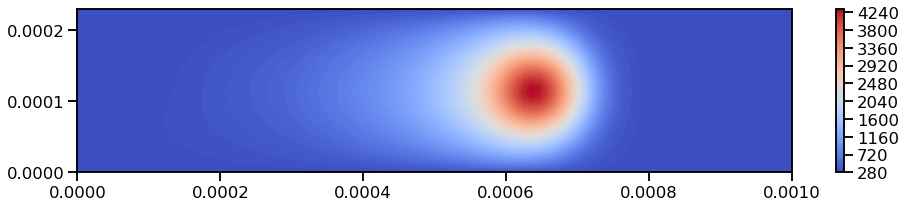

In [5]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [6]:
weights_2 = np.array([1, 1e-1])
#dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=5000, maxls=50, ftol=1e-6)
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=5000, maxfun=5000, maxls=50)
#model.compile('L-BFGS', loss_weights=weights*weights_2)
model.compile('L-BFGS', loss_weights=weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 9.637483 s

Training model...

Step      Train loss              Test loss               Test metric
2         [1.23e+10, 2.55e+11]    [1.55e+10, 2.55e+11]    []  
100       [9.86e+09, 3.29e+10]                                
200       [8.45e+09, 3.23e+10]                                
300       [8.18e+09, 3.20e+10]                                
400       [8.18e+09, 3.20e+10]                                
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 40176726820.323631
  Number of iterations: 247
  Number of functions evaluations: 440
442       [8.18e+09, 3.20e+10]    [1.27e+10, 3.20e+10]    []  

Best model at step 442:
  train loss: 4.02e+10
  test loss: 4.47e+10
  test metric: []

'train' took 34.632583 s



In [7]:
model.save('transfer/{}'.format(P))

INFO:tensorflow:transfer/220-442.ckpt is not in all_model_checkpoint_paths. Manually adding it.


'transfer/220-442.ckpt'

In [8]:
np.save('surface_fields/losses/train_{}'.format(P), np.array(losshistory.loss_train))

In [9]:
data = np.genfromtxt('surface_fields/surface_{}.csv'.format(P), delimiter = ',',skip_header = True)
x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)

np.save('surface_fields/prelearn/{}.npy'.format(P), Y[:,0])

2023-02-28 12:05:54.766563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Text(0, 0.5, '$T$[K]')

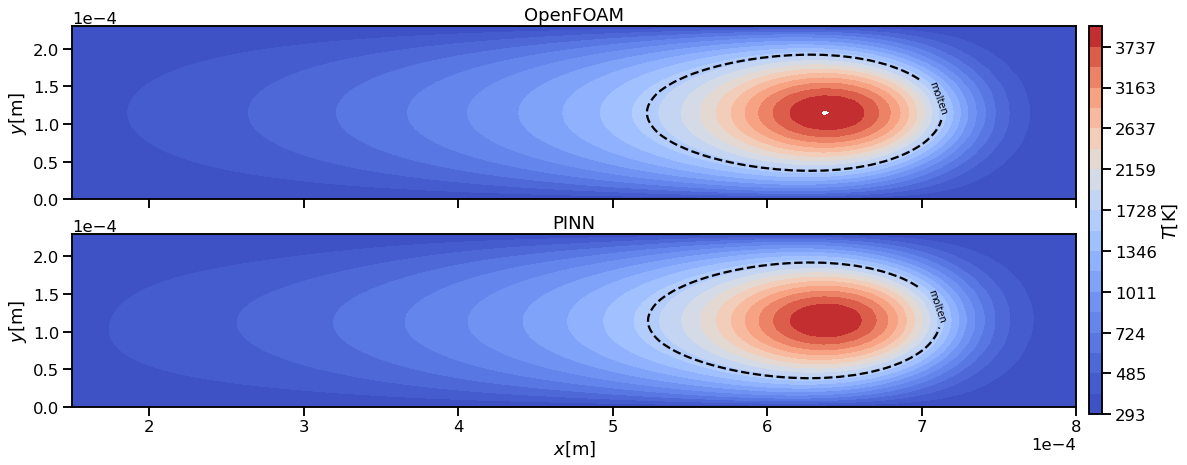

In [10]:
%matplotlib inline

data = np.genfromtxt('surface_fields_2/surface_{}.csv'.format(P), delimiter = ',',skip_header = True)
x, y, z, T = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')

X = np.vstack((x, y, np.ones(len(x))*z.max(), np.ones(len(x))*t_max)).T
Y = model.predict(X)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
T_pred = griddata((x, y), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

#Plotting

fig, (ax1, ax2) = plt.subplots(ncols = 1, nrows = 2, figsize = (18, 7), sharex=True)

intervals = np.linspace(np.sqrt(Ti.min()), np.sqrt(T_pred.max()), 20)**2

im = ax1.contourf(xi, yi, Ti, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = T_pred.max())
CS = ax2.contourf(xi, yi, T_pred, intervals, cmap=plt.cm.coolwarm, vmin = Ti.min(), vmax = T_pred.max())

im2 = ax1.contour(xi, yi, Ti, [1633], linestyles='--', colors='black')
CS2 = ax2.contour(xi, yi, T_pred, [1633], linestyles='--', colors='black')


ax1.clabel(im2, inline=True, fontsize=10, fmt=lambda x : 'molten')
ax2.clabel(CS2, inline=True, fontsize=10, fmt=lambda x : 'molten')

ax1.set_ylabel('$y$[m]')
ax1.set_title('OpenFOAM')
ax2.set_ylabel('$y$[m]')
ax2.set_xlabel('$x$[m]')
ax2.set_title('PINN')
ax2.set_xlim([0.00015, 0.0008])
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))
cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('$T$[K]')

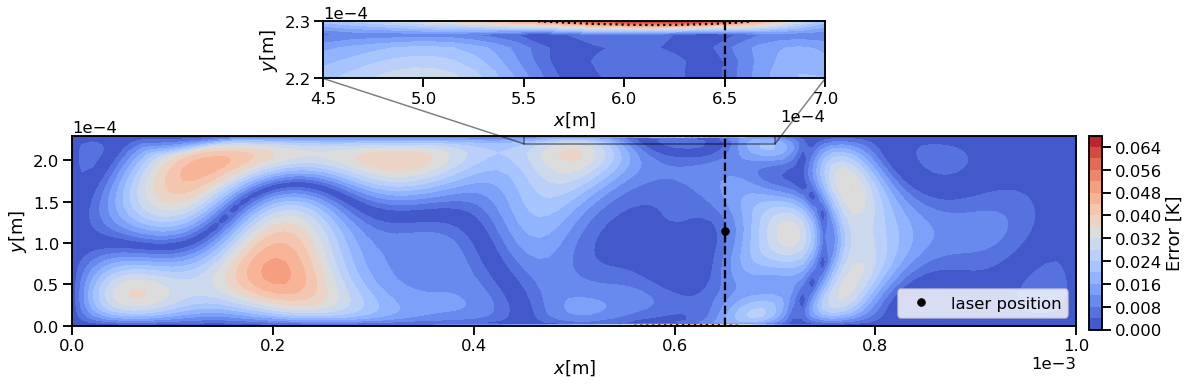

In [12]:
fig, ax = plt.subplots(figsize = (18, 3.5))

im = ax.contourf(xi, yi, np.abs(Ti - T_pred)/Ti, 20, cmap=plt.cm.coolwarm)
im2 = ax.contour(xi, yi, np.abs(Ti - T_pred)/Ti, [0.05], linestyles=':', colors='black')
ax.set_ylabel('$y$[m]')
ax.set_xlabel('$x$[m]')
ax.plot([x_max/4 + t_max*v], [y_max/2], 'k.', markersize = 15, label = 'laser position')
ax.vlines([x_max/4 + t_max*v], 0, y_max, linestyle = '--', color = 'black')
# inset axes....
axins = ax.inset_axes([0.25, 1.3, 0.5, 0.3])
axins.contourf(xi, yi, np.abs((Ti - T_pred))/Ti, 20, cmap=plt.cm.coolwarm)
im2 = axins.contour(xi, yi, np.abs(Ti - T_pred)/Ti, [0.05], linestyles=':', colors='black')
axins.vlines([x_max/4 + t_max*v], 0.00022, y_max, linestyle = '--', color = 'black')
# subregion of the original image
x1, x2, y1, y2 = (0.00045, 0.0007, 0.00022, y_max)
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_ylabel('$y$[m]')
axins.set_xlabel('$x$[m]')
ax.indicate_inset_zoom(axins, edgecolor="black")

ax.ticklabel_format(style='sci',  scilimits=(0, 0))
axins.ticklabel_format(style='sci',  scilimits=(0, 0))

cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
fig.colorbar(im, cax=cbar_ax, label = 'Error [K]')

ax.legend(loc = 'lower right')